In [1]:
import gradio as gr
import torch
from src.train import train
from sklearn.datasets import load_breast_cancer
import pandas as pd

In [2]:
def load_data(dataset,target_name):
    if target_name not in dataset.columns:
        raise KeyError(f"Target column '{target_name}' not found in DataFrame columns: {list(dataset.columns)}")

    y = dataset[target_name].copy()
    X = dataset.drop(columns=[target_name]).copy()
    return X, y

In [3]:
X, y = load_breast_cancer(return_X_y=True)
breast = load_breast_cancer()
feature_names = breast.feature_names
model,data = train(X=X, y=y,save=True,model_state=None)

Target labels: [0 1]


wandb: Currently logged in as: lamastico2-0 (lamastico2-0-hes-so-valais-wallis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


lr: 0.001
Epoch 01 | Loss: 0.6779 | Acc: 0.6276 | Val Loss: 0.6709 | Val Acc: 0.6228
Epoch 02 | Loss: 0.6747 | Acc: 0.6276 | Val Loss: 0.6681 | Val Acc: 0.6228
Epoch 03 | Loss: 0.6716 | Acc: 0.6276 | Val Loss: 0.6653 | Val Acc: 0.6228
Epoch 04 | Loss: 0.6684 | Acc: 0.6276 | Val Loss: 0.6626 | Val Acc: 0.6228
Epoch 05 | Loss: 0.6654 | Acc: 0.6276 | Val Loss: 0.6600 | Val Acc: 0.6228
Epoch 06 | Loss: 0.6624 | Acc: 0.6276 | Val Loss: 0.6574 | Val Acc: 0.6228
Epoch 07 | Loss: 0.6595 | Acc: 0.6276 | Val Loss: 0.6549 | Val Acc: 0.6228
Epoch 08 | Loss: 0.6566 | Acc: 0.6276 | Val Loss: 0.6524 | Val Acc: 0.6228
Epoch 09 | Loss: 0.6538 | Acc: 0.6276 | Val Loss: 0.6500 | Val Acc: 0.6228
Epoch 10 | Loss: 0.6511 | Acc: 0.6276 | Val Loss: 0.6475 | Val Acc: 0.6228
Epoch 11 | Loss: 0.6483 | Acc: 0.6276 | Val Loss: 0.6450 | Val Acc: 0.6228
Epoch 12 | Loss: 0.6457 | Acc: 0.6276 | Val Loss: 0.6425 | Val Acc: 0.6228
Epoch 13 | Loss: 0.6430 | Acc: 0.6276 | Val Loss: 0.6399 | Val Acc: 0.6228
Epoch 14 | Loss

Train Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Train Accuracy,0.62757
Train Loss,0.53852
Val Accuracy,0.62281
Val Loss,0.53211


In [4]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [5]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(data["X_test_tensor"])
    y_pred = (y_pred_probs > 0.5).int()

In [6]:
y_pred_np = y_pred.numpy().flatten()
y_true_np = data["y_test_tensor"].numpy().flatten()

print(classification_report(y_true_np, y_pred_np, target_names=["malignant", "benign"]))


              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00        42
      benign       0.63      1.00      0.77        72

    accuracy                           0.63       114
   macro avg       0.32      0.50      0.39       114
weighted avg       0.40      0.63      0.49       114



c:\Users\robin\OneDrive\Bureau\projetsemstre\xai-on-the-wall\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\robin\OneDrive\Bureau\projetsemstre\xai-on-the-wall\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\robin\OneDrive\Bureau\projetsemstre\xai-on-the-wall\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

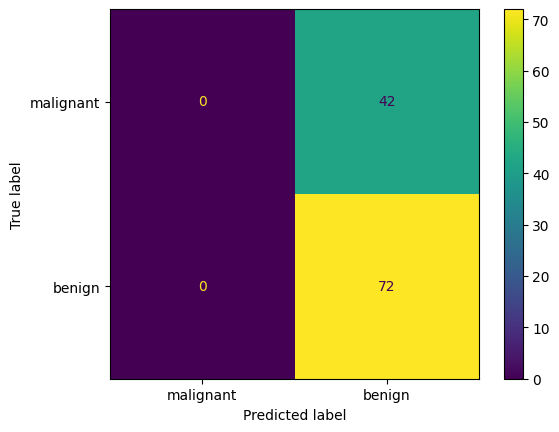

In [7]:
cm = confusion_matrix(y_true_np, y_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["malignant", "benign"])
disp.plot()

# DEXIRE

In [8]:
from explainer.dexire import get_dexire_rules

In [9]:
rules = get_dexire_rules(model,data,feature_names=feature_names)

y_train unique values: [0 1]
class_names: ['malignant', 'benign']


In [10]:
rules

[IF [] THEN malignant]

# CIU

In [11]:
from explainer.ciu import get_explainer_CIU, get_ciu_instance
import pandas as pd

In [12]:
CIU_model = get_explainer_CIU(model, data,output_names=["malignant", "benign"], feature_names=feature_names)

In [13]:
X_test_df = pd.DataFrame(data["X_test"],  columns=feature_names)
res = get_ciu_instance(CIU_model, X_test_df.iloc[[0]])

In [14]:
display(res)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
mean radius,0.046441,0.677736,0.008254,malignant,0.647466,mean radius,0.615991,0.662433,[0],[-0.3599288447983384],0.5,None,None
mean texture,0.012273,0.040004,-0.005645,malignant,0.647466,mean texture,0.646975,0.659248,[1],[-1.3891772795184163],0.5,None,None
mean perimeter,0.042547,0.747480,0.010530,malignant,0.647466,mean perimeter,0.615663,0.658210,[2],[-0.37685051740363934],0.5,None,None
mean area,0.056962,0.782133,0.016071,malignant,0.647466,mean area,0.602915,0.659876,[3],[-0.42686881208578564],0.5,None,None
mean smoothness,0.137162,0.337837,-0.022243,malignant,0.647466,mean smoothness,0.601128,0.738290,[4],[1.2126391194849206],0.5,None,None
mean compactness,0.084405,0.781300,0.023743,malignant,0.647466,mean compactness,0.581520,0.665926,[5],[-0.30324232229162407],0.5,None,None
mean concavity,0.041478,0.850975,0.014558,malignant,0.647466,mean concavity,0.612170,0.653647,[6],[-0.6377839420855458],0.5,None,None
mean concave points,0.017325,0.698690,0.003442,malignant,0.647466,mean concave points,0.635361,0.652686,[7],[-0.3848241849220292],0.5,None,None
mean symmetry,0.042238,0.742919,0.010260,malignant,0.647466,mean symmetry,0.616087,0.658325,[8],[-0.9807114107976288],0.5,None,None
mean fractal dimension,0.061868,0.442809,-0.003538,malignant,0.647466,mean fractal dimension,0.620070,0.681939,[9],[0.2781892250649481],0.5,None,None


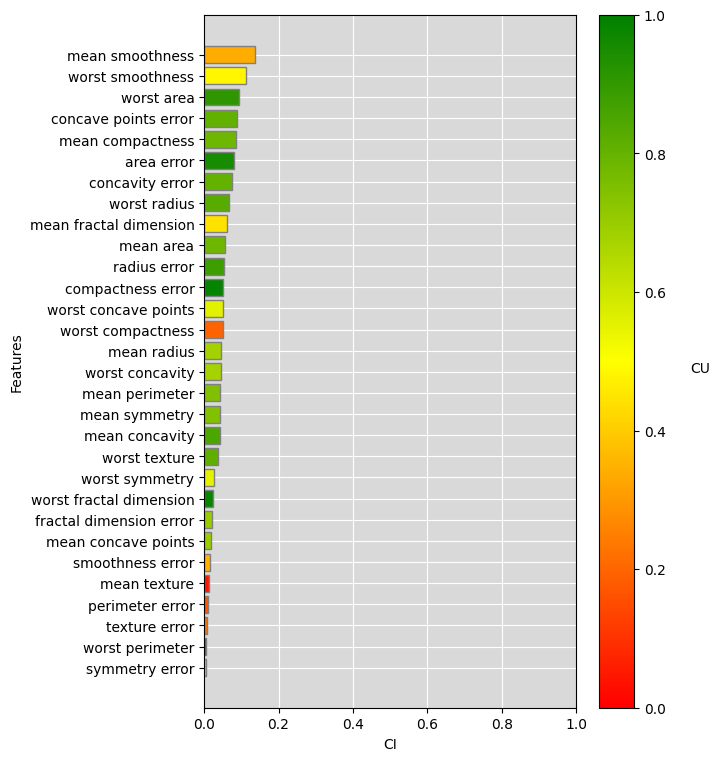

In [15]:
p = CIU_model.plot_ciu(res, figsize=(6,9))

# DEXIRE-EVO

In [16]:
from dexire_evo.ga_engine import GAEngine
from dexire_evo.rule_formatter import format_if_elif_else
from sklearn.metrics import accuracy_score, classification_report
from src.config import Config
from explainer.dexire_evo import get_dexire_evo_rules

In [17]:
best, test_acc, uncov_te, engine = get_dexire_evo_rules(feature_names, model, data)


GEN 001: fid=1.000, preds=8.0, uncov=0.0
GEN 010: fid=1.000, preds=2.0, uncov=0.0
GEN 020: fid=1.000, preds=2.0, uncov=0.0
GEN 030: fid=1.000, preds=2.0, uncov=0.0
GEN 040: fid=1.000, preds=2.0, uncov=0.0
GEN 050: fid=1.000, preds=2.0, uncov=0.0
GEN 060: fid=1.000, preds=2.0, uncov=0.0
GEN 070: fid=1.000, preds=2.0, uncov=0.0
GEN 080: fid=1.000, preds=2.0, uncov=0.0
GEN 090: fid=1.000, preds=2.0, uncov=0.0
GEN 100: fid=1.000, preds=2.0, uncov=0.0
GEN 110: fid=1.000, preds=2.0, uncov=0.0
GEN 120: fid=1.000, preds=2.0, uncov=0.0
GEN 130: fid=1.000, preds=2.0, uncov=0.0
GEN 140: fid=1.000, preds=2.0, uncov=0.0
GEN 150: fid=1.000, preds=2.0, uncov=0.0
GEN 160: fid=1.000, preds=2.0, uncov=0.0
GEN 170: fid=1.000, preds=2.0, uncov=0.0
GEN 180: fid=1.000, preds=2.0, uncov=0.0
GEN 190: fid=1.000, preds=2.0, uncov=0.0
GEN 200: fid=1.000, preds=2.0, uncov=0.0


In [18]:
print("\nRules in IF–ELIF–ELSE form (GA):")
print(format_if_elif_else(best, feature_names, engine.operator_set))


Rules in IF–ELIF–ELSE form (GA):
if worst smoothness < 3.11: class = 1
else mean compactness >= -1.46: class = 1


In [19]:
print("\n=== FINAL GA RESULTS ===")
print(f"Fidelity (train vs model): {best.fitness.values[0]:.3f}")
print(f"# Predicates             : {best.fitness.values[1]}")
print(f"Uncovered (train)        : {best.fitness.values[2]}")
print(f"Test accuracy (matched)  : {test_acc:.3f} | Uncov test: {uncov_te}")


=== FINAL GA RESULTS ===
Fidelity (train vs model): 1.000
# Predicates             : 2.0
Uncovered (train)        : 0.0
Test accuracy (matched)  : 0.632 | Uncov test: 0


In [20]:
import torch.nn as nn
import pandas as pd

def build_mlp_from_layer_df(input_size: int, df) -> nn.Module:
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df, columns=["units", "activation"])

    act_map = {
        "relu": nn.ReLU,
        "tanh": nn.Tanh,
        "leaky_relu": nn.LeakyReLU,
        "elu": nn.ELU,
    }

    layers = []
    prev = input_size

    for _, row in df.iterrows():
        try:
            units = int(row["units"])
        except (ValueError, TypeError):
            continue
        if units <= 0:
            continue

        act_name = str(row["activation"]).strip().lower() or "relu"
        if act_name not in act_map:
            act_name = "relu"

        layers.append(nn.Linear(prev, units))
        layers.append(act_map[act_name]())
        prev = units

    if not layers:
        layers = [
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        ]
        prev = 8

    layers.append(nn.Linear(prev, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [21]:
def run_explanations_for_specific_instance(test_index):
    CIU_model = get_explainer_CIU(model, data,output_names=["malignant", "benign"], feature_names=feature_names)
    X_test_df = pd.DataFrame(data["X_test"],  columns=feature_names)
    res = get_ciu_instance(CIU_model, X_test_df.iloc[[test_index]])
    ciu_plot_out = CIU_model.plot_ciu(res, figsize=(9,6))

    return ciu_plot_out

In [22]:
def run_explanations( dataset_mode, dataset_file, model_mode, layer_config, model_state_file, save_trained_model, learning_rate, epochs, test_index):
    print(layer_config)
    model_architecture = None
    if dataset_mode == "Demo breast cancer":
        X, y = load_breast_cancer(return_X_y=True)
        breast = load_breast_cancer()
        feature_names = breast.feature_names
    else:
        dataset = pd.read_csv(dataset_file.name)
        target_name = dataset.columns[-1]
        X, y = load_data(dataset,target_name)
        feature_names = X.columns.tolist()
    if model_mode == "Load existing model":
        model,data = train(X=X, y=y,model_state=model_state_file,model=model_architecture)
    else:
        model,data = train(X=X, y=y,model=model_architecture,save=save_trained_model,lr=learning_rate, epochs=epochs)
    model.eval()
    dexire_out = get_dexire_rules(model,data,feature_names=feature_names)
    best, test_acc, uncov_te, engine = get_dexire_evo_rules(feature_names, model, data)
    result_str += "Rules in IF–ELIF–ELSE form (GA):\n"
    result_str += "========================\n"
    result_str += format_if_elif_else(best, feature_names, engine.operator_set) + "\n"
    result_str += "========================\n"
    result_str += f"Fidelity (train vs model): {best.fitness.values[0]:.3f}\n"
    result_str += f"# Predicates             : {best.fitness.values[1]}\n"
    result_str += f"Uncovered (train)        : {best.fitness.values[2]}\n"
    result_str += f"Test accuracy (matched)  : {test_acc:.3f} | Uncov test: {uncov_te}\n"
    dexire_evo_out = result_str
    return dexire_out, dexire_evo_out

# Visibility toggle helpers

In [23]:
def toggle_dataset_file(dataset_mode):
    return gr.update(visible=(dataset_mode == "Upload CSV"))


def toggle_model_widgets(model_mode):
    load_mode = (model_mode == "Load existing model")
    return (
        gr.update(visible=load_mode),       # model_state_file
        gr.update(visible=not load_mode),   # train_cfg_group
        gr.update(visible=not load_mode),   # save_trained_model
        gr.update(visible=not load_mode),   # learning_rate
        gr.update(visible=not load_mode),   # epochs
    )

# Gradio Interface

In [ ]:
with gr.Blocks(title="XAI on the Wall") as main:
    gr.Markdown("## XAI on the Wall – CIU, DexiRE & DexiRE-Evo")

    with gr.Row():
        with gr.Column(scale=1):
            # ── Dataset section ──
            gr.Markdown("### Dataset")

            dataset_mode = gr.Radio(
                ["Demo breast cancer", "Upload CSV"],
                value="Demo breast cancer",
                label="Dataset source",
            )

            dataset_file = gr.File(
                label="Upload dataset (CSV, last column = target)",
                file_types=[".csv"],
                interactive=True,
                visible=False,
            )

            # ── Model section ──
            gr.Markdown("### Model")

            model_mode = gr.Radio(
                ["Train new model", "Load existing model"],
                value="Train new model",
                label="Model source",
            )

            model_state_file = gr.File(
                label="Model state (.pth) (used if 'Load existing model')",
                file_types=[".pth", ".pt"],
                interactive=True,
                visible=False,  
            )

            with gr.Group(visible=False) as train_cfg_group:
                save_trained_model = gr.Checkbox(
                    value=False,
                    label="Save trained model to disk",
                )
                learning_rate = gr.Number(
                    value=0.001,
                    precision=3,
                    label="Learning rate",
                )
                epochs = gr.Number(
                    value=50,
                    precision=0,
                    label="Epochs",
                )

                layer_config = gr.Dataframe(
                    headers=["units", "activation"],
                    datatype=["number", "str"],
                    row_count=(2, "dynamic"), 
                    value=[
                        [16, "relu"],
                        [8, "relu"],
                    ],
                    label="Layers (add/remove rows):",
                )

                   

            run_btn = gr.Button("Train / Load")
            
            test_index = gr.Number(
                value=0,
                precision=0,
                label="Index of test instance to explain (0-based)",
            )
            run_instance_btn = gr.Button("Explain instance")

        # ── Outputs section ──
        with gr.Column(scale=2):

            gr.Markdown("### DexiRE")
            dexire_out = gr.Textbox(
                label="DexiRE rules",
                lines=10,
            )

            gr.Markdown("### DexiRE-Evo")
            dexire_evo_out = gr.Textbox(
                label="DexiRE-Evo rules & metrics",
                lines=10,
            )
            ciu_plot_out = gr.Plot(label="CIU plot")


    # ── Hook up visibility toggles ──

    dataset_mode.change(
        fn=toggle_dataset_file,
        inputs=dataset_mode,
        outputs=dataset_file,
    )

    model_mode.change(
        fn=toggle_model_widgets,
        inputs=model_mode,
        outputs=[model_state_file, train_cfg_group, save_trained_model,learning_rate,epochs],
    )

    main.load(
        fn=toggle_model_widgets,
        inputs=model_mode,
        outputs=[model_state_file, train_cfg_group, save_trained_model,learning_rate,epochs],
    )

    # ── Main run button ──
    run_btn.click(
    fn=run_explanations,
    inputs=[
        dataset_mode,
        dataset_file,
        model_mode,
        layer_config,
        model_state_file,
        save_trained_model,
        learning_rate,
        epochs,
        test_index,
    ],
    outputs=[dexire_out, dexire_evo_out],
)

    run_instance_btn.click(
        fn=run_explanations_for_specific_instance,
        inputs=[
            test_index,
        ],
        outputs=[ciu_plot_out],
    )

In [25]:
main.launch() # add share=True to have a public server 

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
